## Run Structure Function Analysis on All Relevant OpSims (DDF Only)
**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 04-15-21
<br>**Short description:**
This notebook analyze the SFErrorMetric results evaluated on __All__ OpSims in preparation for the SCOC cadence notes on structure function analysis in LSST.

### 0. Software Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')
%matplotlib inline

In [2]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add path
sys.path.insert(0, '../scripts/')
sys.path.insert(0, '../run_info//')

# import convenience functions
from opsimUtils import *

### 1. Read data from disk

In [4]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/DDFAll_g_24_gr_041521/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/DDFAll_g_24_gr_041521/MetricData/'

In [5]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slic

In [6]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'SFError_24.15_u_ECDFS'), (2, 'SFError_23.85_r_COSMOS'), (3, 'SFError_24.15_u_EDFS'), (4, 'SFError_23.85_r_ELAISS1'), (5, 'SFError_24.15_u_COSMOS'), (6, 'SFError_23.85_r_XMM-LSS'), (7, 'SFError_24.15_u_ELAISS1'), (8, 'SFError_23.85_r_ECDFS'), (9, 'SFError_24.15_u_XMM-LSS'), (10, 'SFError_23.85_r_EDFS')]


#### Keep only result for the relevant OpSims

In [7]:
# read in the list of relevant runs
runs_file = open('../run_info/runs_list.txt', 'r')
runs_list = runs_file.read().split('\n')
runs_list[:5]

['agnddf_v1.5_10yrs',
 'alt_dust_v1.5_10yrs',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs',
 'barebones_nexp2_v1.6_10yrs',
 'barebones_v1.6_10yrs']

In [8]:
# select metric results for the relevant opsims
final_bundleDicts = {key:value for (key, value) in bundleDicts.items() if key in runs_list}
final_resultDbs = {key:value for (key, value) in resultDbsView.items() if key in runs_list}

### 2. Make plots

In [9]:
# take Lynne's notes on families
import run_infos as ri

# gather family info, but remove version_baselines
families = ri.FamilyInfo()
fam_db = {key:value for (key, value) in families.family.items() if key != 'version_baselines'}
family_ls = list(fam_db.keys())
comp_runs = {key:value for (key, value) in families.family_baseline.items() if key != 'version_baselines'}

In [10]:
KeyNames = [key[1] for key in bd_keys]
KeyNames

['SFError_24.15_u_ECDFS',
 'SFError_23.85_r_COSMOS',
 'SFError_24.15_u_EDFS',
 'SFError_23.85_r_ELAISS1',
 'SFError_24.15_u_COSMOS',
 'SFError_23.85_r_XMM-LSS',
 'SFError_24.15_u_ELAISS1',
 'SFError_23.85_r_ECDFS',
 'SFError_24.15_u_XMM-LSS',
 'SFError_23.85_r_EDFS']

#### 2.1 Get summary statistics (Median, Mean, etc.)

In [11]:
# get summary names
summaryNames = getSummaryStatNames(final_resultDbs['baseline_v1.5_10yrs'], 
                                   KeyNames[0])[0]['StatNames']

# loop through metric Keys and summaries -> combine into one pandas df
summary_dfs = []
for KeyName in KeyNames:
    for summaryName in ['Median']:
        summary_df = getSummary(
            final_resultDbs, 
            KeyName, 
            summaryName)[['summaryValue', 'runName']].rename(columns={'summaryValue':
                                                            f'{KeyName}_{summaryName}'})
        summary_dfs.append(summary_df.set_index('runName'))

summary_df_all = summary_dfs[0].join(summary_dfs[1:], how='outer').reset_index().rename(columns={'index': 'runName'})

In [12]:
# assign family
unique_comp_runs = np.unique(list(comp_runs.values()))
summary_df_all['family'] = ''
for familyName in comp_runs:
    non_comp_runs = [run for run in fam_db[familyName] if run is not comp_runs[familyName]]
    summary_df_all.loc[summary_df_all.runName.isin(non_comp_runs), 'family'] = familyName

# if not assigned, it must be one of the baselines
summary_df_all.loc[summary_df_all.runName.isin(unique_comp_runs), 'family'] = 'baseline'

# sort by family
summary_df_all = summary_df_all.sort_values('family').set_index('runName')

#### 2.2 `SFError_24.15_u` 
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

__!!__ All metric values will be normalized to the result of the `XMM-LSS` field from comparision

In [13]:
from radar_plot import *
from matplotlib.colors import ListedColormap

In [14]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)

    return ListedColormap(color_list, name=cmap_name)

In [15]:
def radar(df, rgrids=[0.7, 1.0, 1.3, 1.6], cmap=None,
          alpha=0.1, legend=True, figsize=(8.5, 5), fill=False,
          bbox_to_anchor=(1.6, 0.5)):
    """
    make a radar plot!
    """
    theta = radar_factory(np.size(df.columns), frame='polygon')
    fig, axes = plt.subplots(figsize=figsize, subplot_kw=dict(projection='radar'))
    axes.set_rgrids(rgrids)

    ix = 0
    my_cmap = discrete_cmap(len(df), cmap)
    for i, row in df.iterrows():
        axes.plot(theta, row.values, 'o-', label=i, color=my_cmap(ix), markersize=4)
        if fill:
            axes.fill(theta, row.values, alpha=alpha)
        ix += 1

    variables = df.columns.values

    axes.set_varlabels(variables)
    if legend:
        axes.legend(bbox_to_anchor=bbox_to_anchor, borderaxespad=0, loc='lower right')
    axes.set_ylim([np.min(rgrids), np.max(rgrids)])

    return fig, axes

In [16]:
# define normalizing run
norm_run = 'baseline_v1.5_10yrs'
norm_metric_u = summary_df_all.loc[norm_run, 'SFError_24.15_u_XMM-LSS_Median']
# norm_metric_g = summary_df_all.loc[norm_run, 'SFError_24_g_XMM-LSS_Median']
norm_metric_r = summary_df_all.loc[norm_run, 'SFError_23.85_r_XMM-LSS_Median']

##### 2.2.1 __Best one from each family + All baseline comparison runs__

In [18]:
# make a separate df only containing medians
u_median_24_15_cols = [col for col in summary_df_all.columns 
                 if '_Median' in col and '_u_' in col and '_24.15_' in col]
u_median_24_15_df = summary_df_all.loc[:, u_median_24_15_cols].join(summary_df_all.family)
u_median_24_15_df = u_median_24_15_df[u_median_24_15_df.columns.sort_values(ascending=True)]

In [19]:
# normalize to XMM-LSS
u_median_24_15_normed = u_median_24_15_df.copy()
u_median_24_15_normed.loc[:, u_median_24_15_cols] = \
norm_metric_u/u_median_24_15_df.loc[:, u_median_24_15_cols]

# compute sum of normalized metric for ranking
u_median_24_15_normed['accum_metric'] = u_median_24_15_normed.sum(axis=1)
u_median_24_15_normed.sort_values('accum_metric', inplace=True, ascending=False)

In [20]:
## sort by family and sum of normalized metric
# take the best from each family (higher is better), but keep all three baselines
best_u_family_no_baseline = u_median_24_15_normed[
    u_median_24_15_normed.family != 'baseline'
].sort_values(['family', 'accum_metric'], 
              ascending=[True, False]).drop_duplicates(subset='family')

best_u_family = pd.concat([u_median_24_15_normed[u_median_24_15_normed.family == 'baseline'], 
                           best_u_family_no_baseline], 
                           axis=0).sort_values('accum_metric', ascending=False)

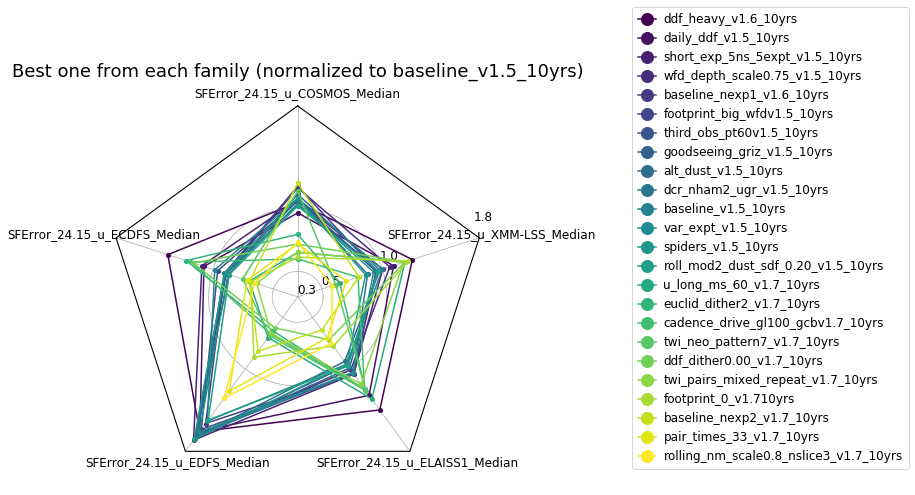

In [21]:
radar(best_u_family.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(2.1, 0.05),
     figsize=(15, 7), rgrids=[0.3, 0.5, 1, 1.8], cmap='viridis', alpha=0.8)
_ = plt.title('Best one from each family (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

##### 2.2.2 __Best 10 & Worst 10 of All__

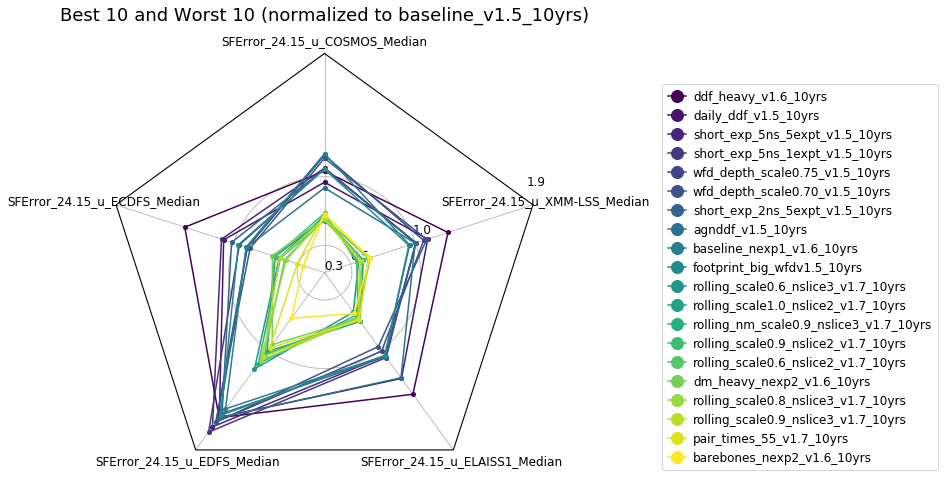

In [22]:
best_worst_u = pd.concat([u_median_24_15_normed.iloc[:10], u_median_24_15_normed.iloc[-10:]])
radar(best_worst_u.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
     figsize=(15, 7), rgrids=[0.3, 0.5, 1, 1.9], cmap='viridis', alpha=0.8)
_ = plt.title('Best 10 and Worst 10 (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

#### 2.3 `SFError_24_g`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

##### 2.3.1 __Best one from each family + All baseline comparison runs__

In [25]:
# # make a separate df only containing medians
# g_median_24_cols = [col for col in summary_df_all.columns 
#                     if '_Median' in col and '_g_' in col and '_24_' in col]
# g_median_24_df = summary_df_all.loc[:, g_median_24_cols].join(summary_df_all.family)
# g_median_24_df = g_median_24_df[g_median_24_df.columns.sort_values(ascending=True)]

# # normalize to XMM-LSS
# g_median_24_normed = g_median_24_df.copy()
# g_median_24_normed.loc[:, g_median_24_cols] = \
# norm_metric_g/g_median_24_df.loc[:, g_median_24_cols]

# # compute sum of normalized metric for ranking
# g_median_24_normed['accum_metric'] = g_median_24_normed.sum(axis=1)
# g_median_24_normed.sort_values('accum_metric', inplace=True, ascending=False)

# ## sort by family and sum of normalized metric
# # take the best from each family (higher is better), but keep all three baselines
# best_g_family_no_baseline = g_median_24_normed[
#     g_median_24_normed.family != 'baseline'
# ].sort_values(['family', 'accum_metric'], 
#               ascending=[True, False]).drop_duplicates(subset='family')

# best_g_family = pd.concat([g_median_24_normed[g_median_24_normed.family == 'baseline'], 
#                            best_g_family_no_baseline], 
#                            axis=0).sort_values('accum_metric', ascending=False)

# radar(best_g_family.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(2.1, 0.0),
#      figsize=(15, 7), rgrids=[0.3, 0.5, 1, 2.1], cmap='viridis', alpha=0.8)
# _ = plt.title('Best one from each family (normalized to baseline_v1.5_10yrs)', fontsize=18)
# plt.tight_layout()

##### 2.3.2 __Best 10 & Worst 10 of All__

In [17]:
# best_worst_g = pd.concat([g_median_24_normed.iloc[:10], g_median_24_normed.iloc[-10:]])
# radar(best_worst_g.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
#      figsize=(15, 7), rgrids=[0.3, 0.5, 1, 2.1], cmap='viridis', alpha=0.8)
# _ = plt.title('Best 10 and Worst 10 (normalized to baseline_v1.5_10yrs)', fontsize=18)
# plt.tight_layout()

#### 2.3 `SFError_23.85_r`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

##### 2.3.1 __Best one from each family + All baseline comparison runs__

In [23]:
# make a separate df only containing medians
r_median_23_85_cols = [col for col in summary_df_all.columns 
                       if '_Median' in col and '_r_' in col and '_23.85_' in col]
r_median_23_85_df = summary_df_all.loc[:, r_median_23_85_cols].join(summary_df_all.family)
r_median_23_85_df = r_median_23_85_df[r_median_23_85_df.columns.sort_values(ascending=True)]

In [24]:
# normalize to XMM-LSS
r_median_23_85_normed = r_median_23_85_df.copy()
r_median_23_85_normed.loc[:, r_median_23_85_cols] = \
norm_metric_r/r_median_23_85_df.loc[:, r_median_23_85_cols]

# compute sum of normalized metric for ranking
r_median_23_85_normed['accum_metric'] = r_median_23_85_normed.sum(axis=1)
r_median_23_85_normed.sort_values('accum_metric', inplace=True, ascending=False)

In [25]:
## sort by family and sum of normalized metric
# take the best from each family (higher is better), but keep all three baselines
best_r_family_no_baseline = r_median_23_85_normed[
    r_median_23_85_normed.family != 'baseline'
].sort_values(['family', 'accum_metric'], 
              ascending=[True, False]).drop_duplicates(subset='family')

best_r_family = pd.concat([r_median_23_85_normed[r_median_23_85_normed.family == 'baseline'], 
                           best_r_family_no_baseline], 
                           axis=0).sort_values('accum_metric', ascending=False)

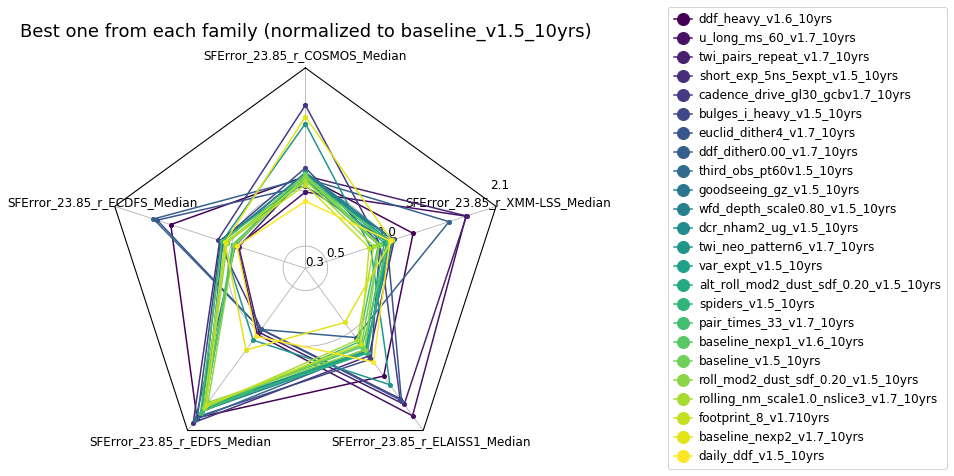

In [26]:
radar(best_r_family.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(2.1, 0.0),
     figsize=(15, 7), rgrids=[0.3, 0.5, 1, 2.1], cmap='viridis', alpha=0.8)
_ = plt.title('Best one from each family (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

##### 2.3.2 __Best 10 & Worst 10 of All__

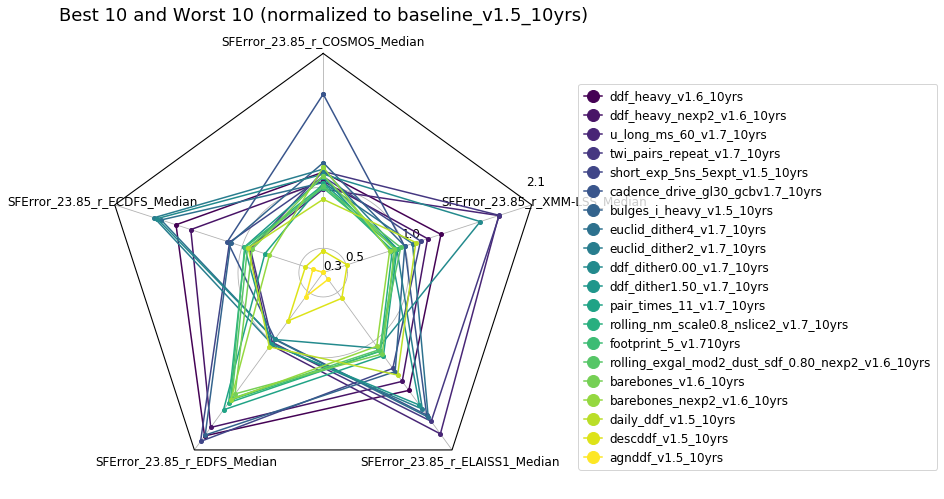

In [27]:
best_worst_r = pd.concat([r_median_23_85_normed.iloc[:10], r_median_23_85_normed.iloc[-10:]])
radar(best_worst_r.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
     figsize=(15, 7), rgrids=[0.3, 0.5, 1, 2.1], cmap='viridis', alpha=0.8)
_ = plt.title('Best 10 and Worst 10 (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

### 3. Cadence Notes Figures

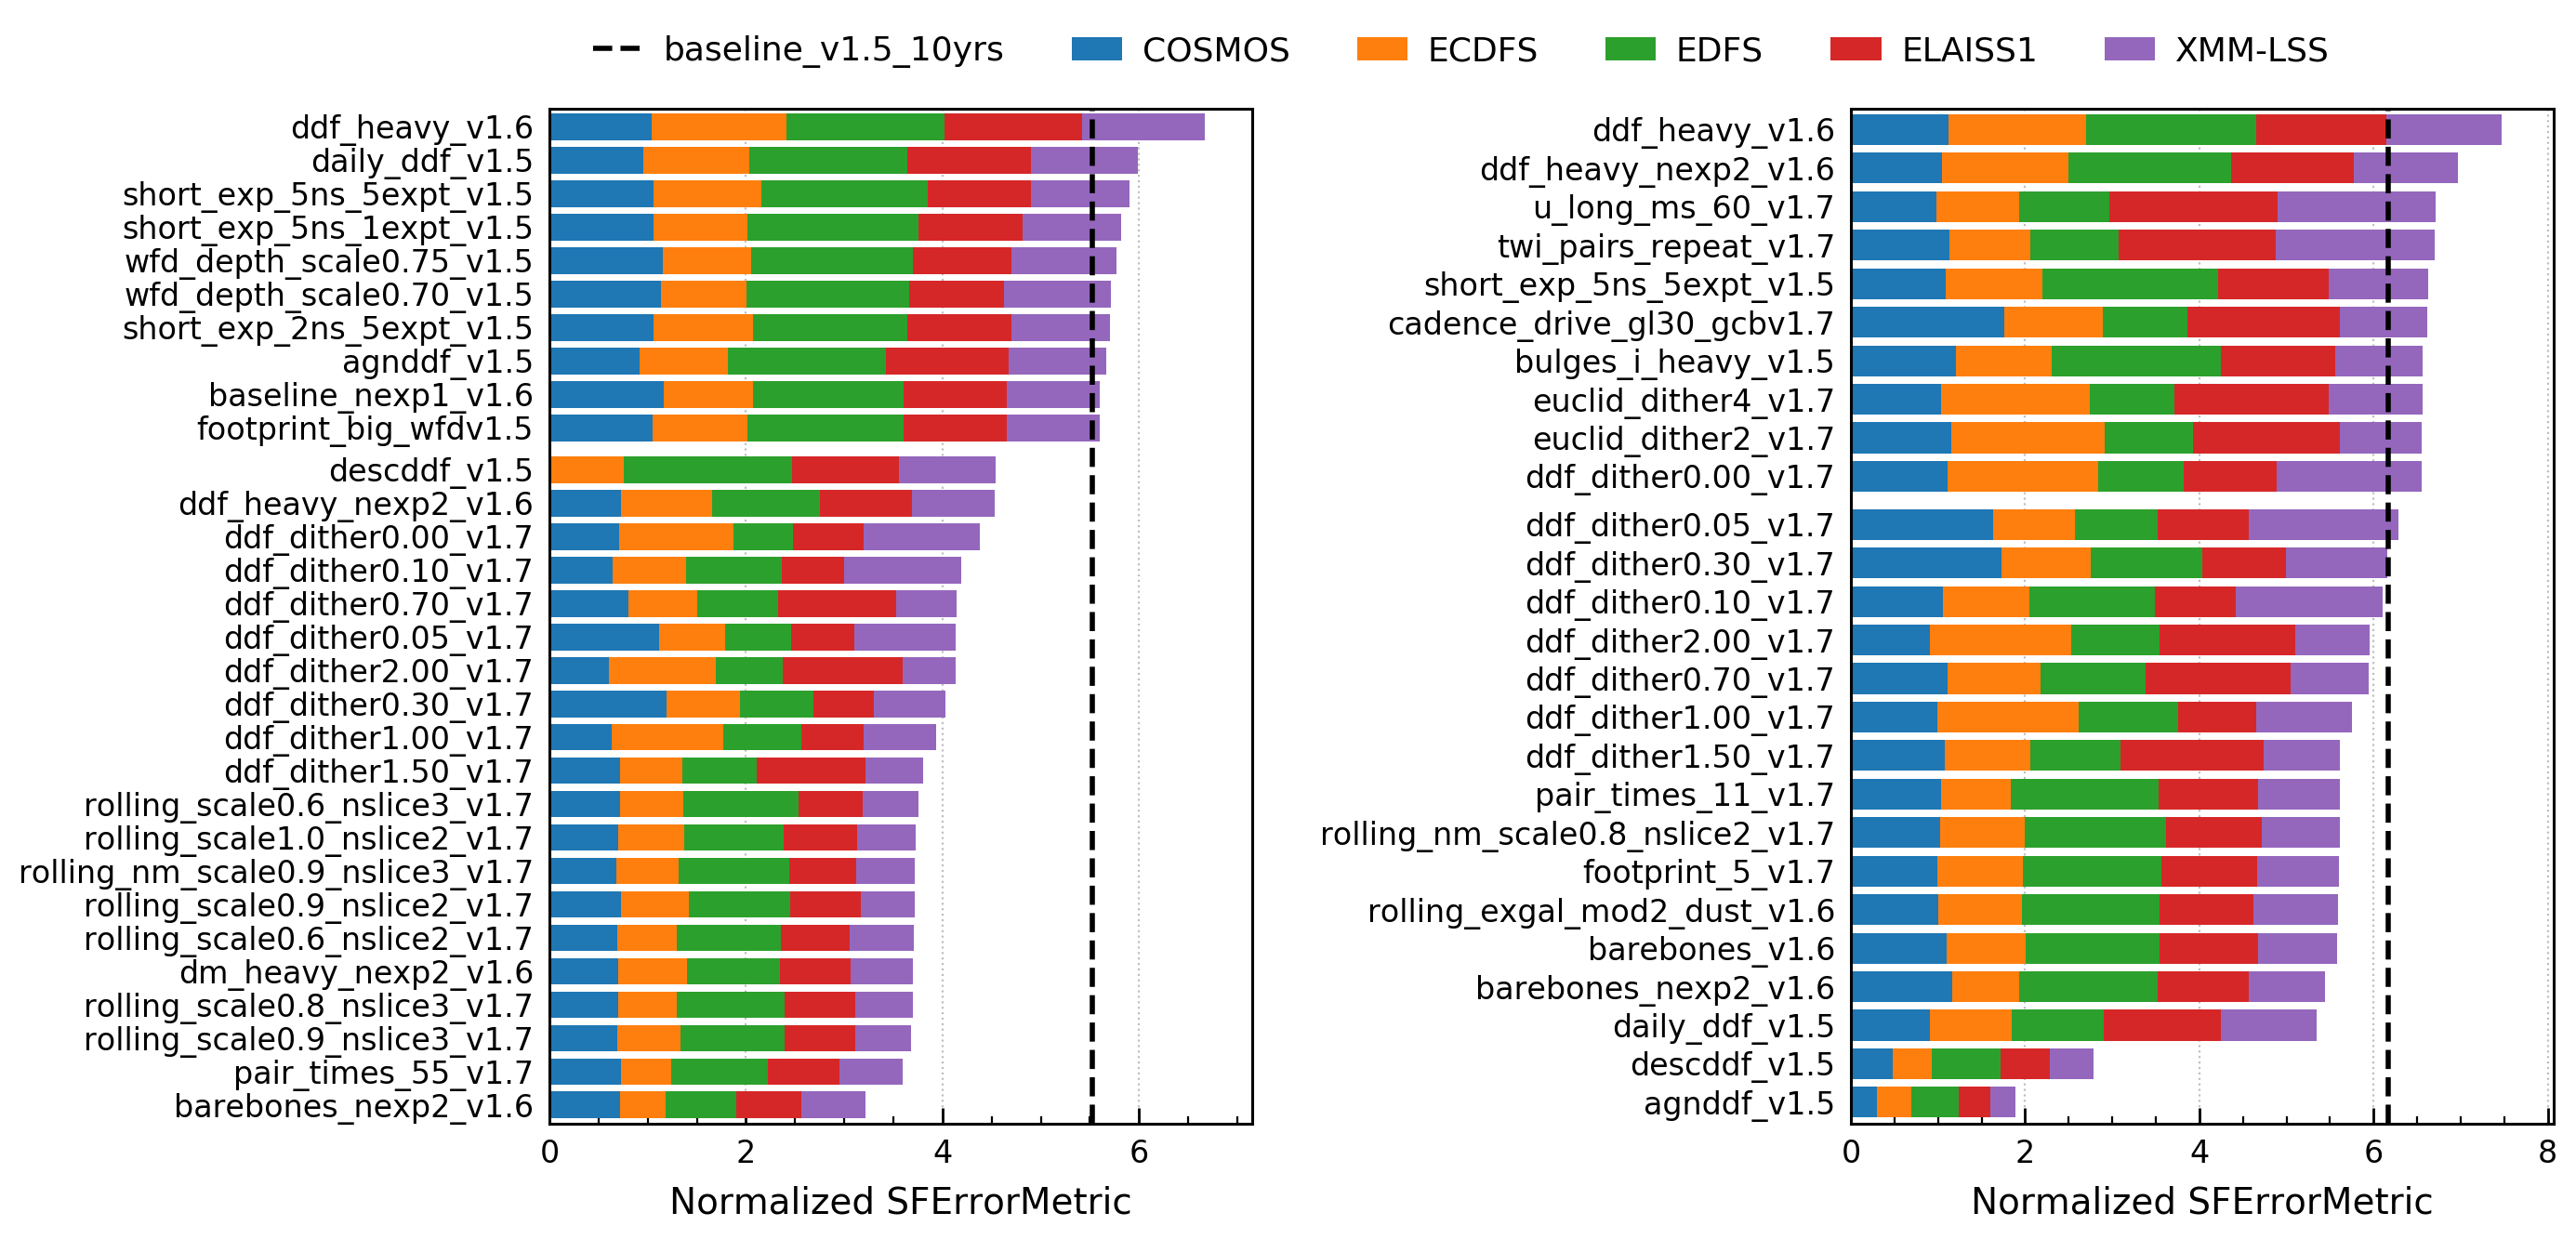

In [29]:
# start plot
fig = plt.figure(figsize=(14, 7), dpi=200)
ax1 = fig.add_axes([0.22, 0.12, 0.27, 0.78])
ax2 = fig.add_axes([0.72, 0.12, 0.27, 0.78])

# get dedicated ddf runs
ddf_runs = [run for run in runs_list if 'ddf_' in run and 'noddf' not in run]

# combine to make u-band, g-band df
u_ddf_runs = np.unique(list(best_worst_u.index) + ddf_runs)
r_ddf_runs = np.unique(list(best_worst_r.index) + ddf_runs)

# -------------
## left: u band
# -------------
baseline_normed_u_sum = u_median_24_15_normed.loc[norm_run, 'accum_metric']
stack_bar_u_best_worst = u_median_24_15_normed.loc[
    u_ddf_runs, :].sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)

left = len(stack_bar_u_best_worst) * [0]
run_labels = [run[:run.find('v1.')+4] 
              if run != 'rolling_exgal_mod2_dust_sdf_0.80_nexp2_v1.6_10yrs'
              else 'rolling_exgal_mod2_dust_v1.6'
              for run in stack_bar_u_best_worst.index]

# replace nan with zero (descddf)
stack_bar_u_best_worst = stack_bar_u_best_worst.fillna(0)

# define bar locs and gap below best 10
y_locs = np.arange(len(run_labels), dtype=float)
gap_size = 0.25
y_locs[-10:] += gap_size
u_labels = [col.split('_')[3] for col in stack_bar_u_best_worst.columns]

for idx, name in enumerate(stack_bar_u_best_worst.columns):
    ax1.barh(y_locs, stack_bar_u_best_worst[name], left = left, color=mpl.cm.tab10.colors[idx])
    left = left + stack_bar_u_best_worst[name] 

# adjust limits and draw grid lines
ax1.set_xlim(0, 7.15)
ax1.set_ylim(-0.55, y_locs[-1] + 0.55)
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle=':', alpha=0.5)

# set ticks
ax1.set_yticks(y_locs)
ax1.set_yticklabels(run_labels)
ax1.yaxis.set_minor_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.FixedLocator([0, 2, 4, 6, 8]))

# mark the baseline comparison run metric
ax1_ylim = ax1.get_ylim()
ax1.vlines(baseline_normed_u_sum, ymin=ax1_ylim[0], ymax=ax1_ylim[1], 
           linestyle='dashed', linewidth=2, label=norm_run)

# title, legend, labels
ax1.set_xlabel('Normalized SFErrorMetric')
ax1.legend([norm_run]+u_labels, bbox_to_anchor=([0.0, 1.115, 0, 0]), ncol=6, 
           frameon=False, fontsize=13, loc=2)

# --------------
## right: r band
# --------------
baseline_normed_r_sum = r_median_23_85_normed.loc[norm_run, 'accum_metric']
stack_bar_r_best_worst = r_median_23_85_normed.loc[
    r_ddf_runs, :].sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)

left = len(stack_bar_r_best_worst) * [0]
run_labels = [run[:run.find('v1.')+4] 
              if run != 'rolling_exgal_mod2_dust_sdf_0.80_nexp2_v1.6_10yrs'
              else 'rolling_exgal_mod2_dust_v1.6'
              for run in stack_bar_r_best_worst.index]

# replace nan with zero (descddf)
stack_bar_r_best_worst = stack_bar_r_best_worst.fillna(0)

# define bar locs and gap below best 10
y_locs = np.arange(len(run_labels), dtype=float)
gap_size = 0.25
y_locs[-10:] += gap_size
r_labels = [col.split('_')[3] for col in stack_bar_r_best_worst.columns]

for idx, name in enumerate(stack_bar_r_best_worst.columns):
    ax2.barh(y_locs, stack_bar_r_best_worst[name], left = left, color=mpl.cm.tab10.colors[idx])
    left = left + stack_bar_r_best_worst[name] 

# title, legend, labels
ax2.set_xlabel('Normalized SFErrorMetric')

# adjust limits and draw grid lines
# ax2.set_xlim(0, 8.75)
ax2.set_ylim(-0.55, y_locs[-1] + 0.55)
ax2.set_axisbelow(True)
ax2.xaxis.grid(color='gray', linestyle=':', alpha=0.5)

# set ticks
ax2.set_yticks(y_locs)
ax2.set_yticklabels(run_labels)
ax2.yaxis.set_minor_locator(plt.NullLocator())

# mark the baseline comparison run metric
ax2_ylim = ax2.get_ylim()
ax2.vlines(baseline_normed_r_sum, ymin=ax2_ylim[0], ymax=ax2_ylim[1], 
           linestyle='dashed', linewidth=2, label=norm_run)

# plt.savefig('figs/sf_cad_note_ddf_u_r.pdf')